In [1]:
#from google.colab import drive
from shutil import copyfile
import tarfile

#drive.mount('/content/gdrive')
#!unzip gdrive/My\ Drive/EuroSAT.zip -d ./dataset/


### Imports

In [2]:
#!pip install -Uqq ipdb
#!pip install torchmetrics
import ipdb

import numpy as np
import pandas as pd
import os
from os.path import join
import glob
from sklearn.model_selection import StratifiedShuffleSplit
from PIL import Image
import random
from tqdm import tqdm


from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn

from torchsummary import summary
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T

from torchmetrics import Accuracy

torch.manual_seed(123)

/home/omirako/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Setup

## Split dataset in train, validation, and test

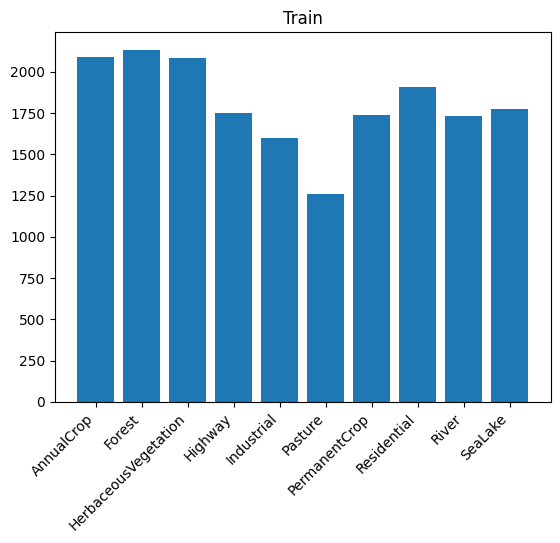

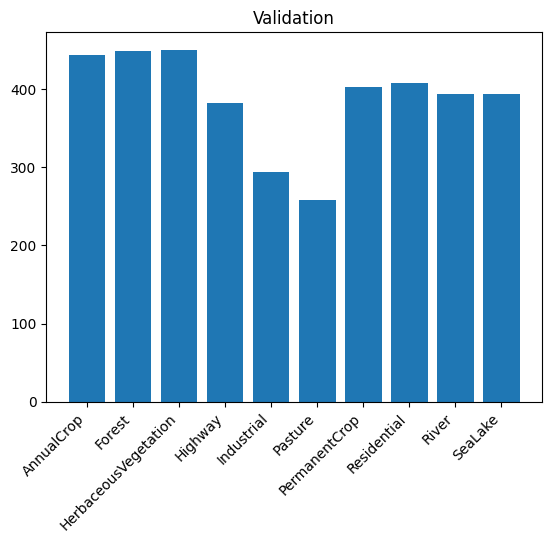

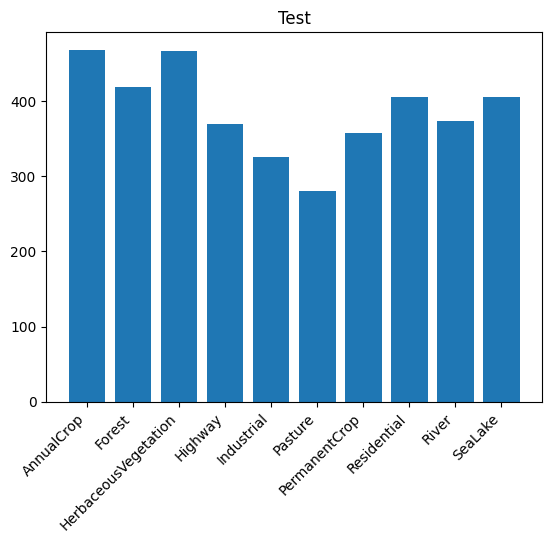

In [3]:
def create_txt(path, name_list):
  file = open(path, 'w')
  for item in name_list:
    file.write(item + "\n")
  file.close()

def plot_distribution(data, mode='train'):
  # Plot distribution train and test
  names = list(data.keys())
  values = list(data.values())

  plt.bar(range(len(data)), values, tick_label=names)
  plt.title(mode)
  plt.xticks(rotation=45, ha="right")
  plt.show()

def show_distribution(files, mode='Train'):
  labels = []
  for f in files:
    labels.append(f.split('/')[0])

  labels_count = Counter(labels)
  stats = OrderedDict(sorted(labels_count.items()))

  plot_distribution(stats, mode=mode)

random.seed(123)

dataset_path = '../datasets/2750'

labels_list = os.listdir(dataset_path)

image_filenames = ['/'.join(x.split('/')[-2:]) for x in glob.glob(join('../datasets/2750' , '*/*.*')) if x.endswith("jpg")]
random.shuffle(image_filenames)

perc = 0.7
train_files = image_filenames[:int(np.round(len(image_filenames)*perc))]
val_files = image_filenames[int(np.round(len(image_filenames)*perc)):int(np.round(len(image_filenames)*perc)+np.round(len(image_filenames)*((1-perc)/2)))]
test_files = image_filenames[int(np.round(len(image_filenames)*perc)+np.round(len(image_filenames)*((1-perc)/2))):]

# Create train and test
create_txt(join(dataset_path, 'train_list.txt'), train_files)
create_txt(join(dataset_path, 'val_list.txt'), val_files)
create_txt(join(dataset_path, 'test_list.txt'), test_files)

# Show label distributions
show_distribution(train_files, mode='Train')
show_distribution(val_files, mode='Validation')
show_distribution(test_files, mode='Test')


# Vision Transformer

## Patch Embedding

The patch embedding of non-overlapping patches is achieved using 2d convolution with kernel size and stride equal to the patch size

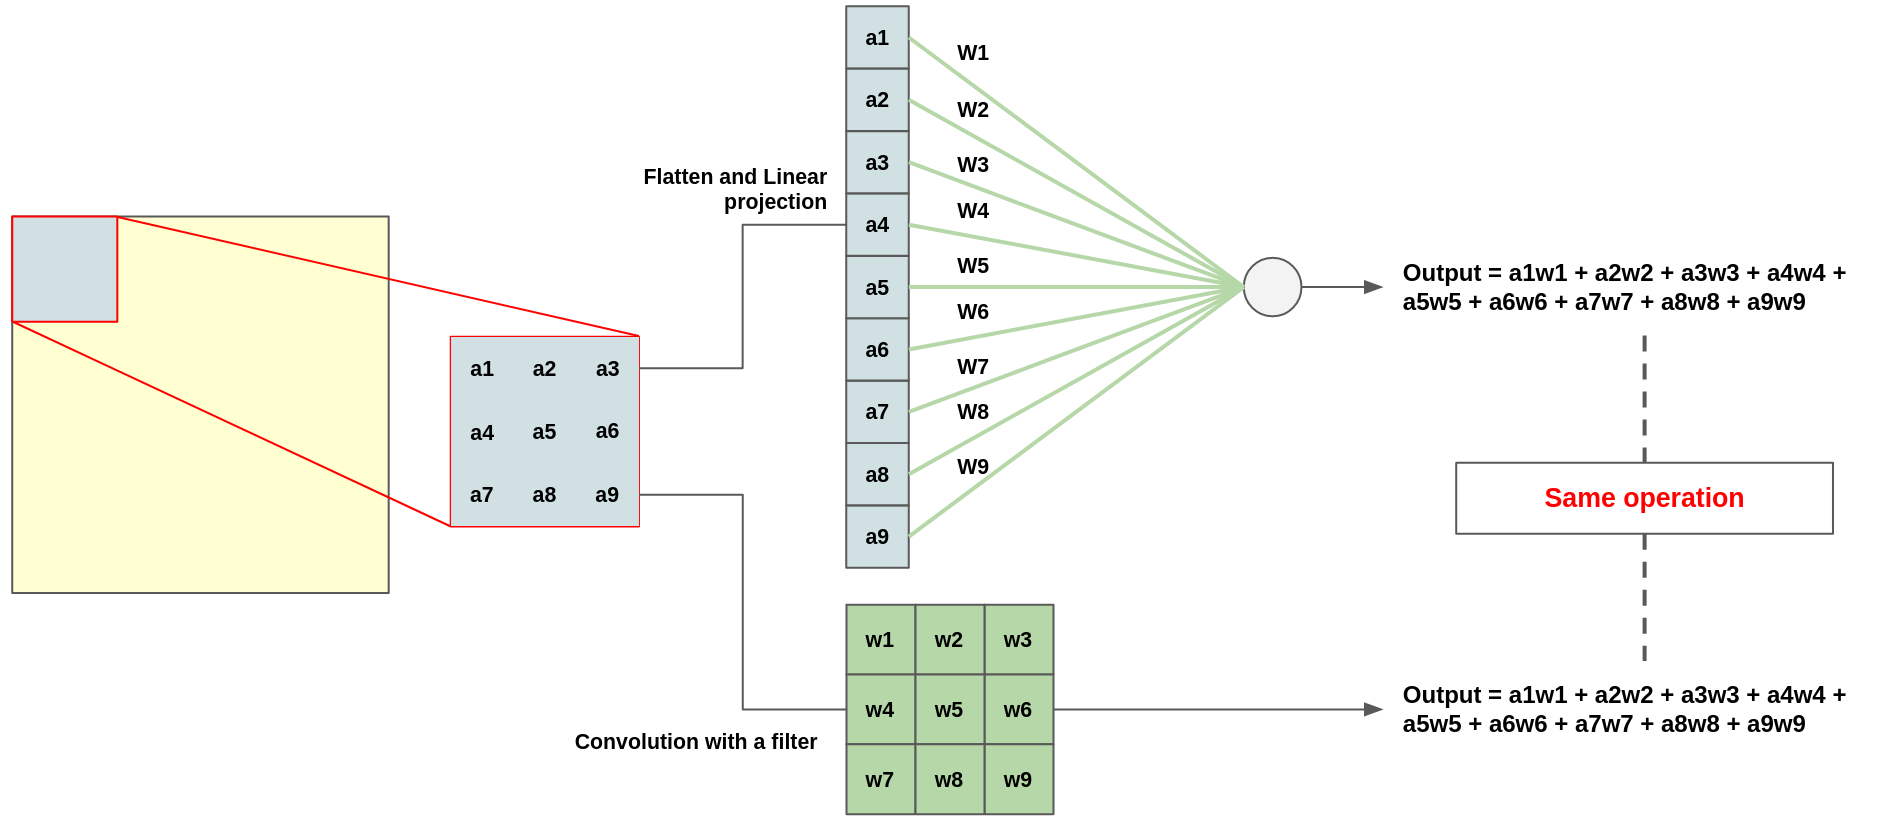

In [4]:
class PatchEmbedding(nn.Module):    
    def __init__(self, im_size, patch_size, in_channels=3, dim_emb=768):
      # Create the Patch Embedding with the following attributes:
      super().__init__()
      
      # Create the embedding using Conv2d
      num_patches = (im_size // patch_size) ** 2
      
      self.num_patches = num_patches
      self.patch_size = patch_size
      self.im_size = im_size
      self.dim_emb = dim_emb
      self.embedding = nn.Conv2d(in_channels, dim_emb, kernel_size=patch_size, stride=patch_size)
      
      
      
    def forward(self, x):
      # Compute the the embedding, the final shape has to be (batch_size, num_patches, dim_emb)
      
      x = self.embedding(x)
      x = x.reshape(x.shape[0], self.num_patches, self.dim_emb) # the final shape has to be (batch_size, num_patches, dim_emb) because we want to use it in the MultiHeadAttention
      
      return x
    
      
  

### Patch embedding test

In [5]:
im_size = 224
patch_size = 16
in_channels = 3
batch_size = 4
dim_emb = 768

test_embedding = PatchEmbedding(im_size, patch_size, in_channels, dim_emb)
batch_sample = torch.rand(batch_size,in_channels,im_size,im_size) # batch of 4 images
batch_embedding = test_embedding(batch_sample)

batch_embedding.shape # expected output --> torch.Size([4, 196, 768])

torch.Size([4, 196, 768])

## Multi-Head Attention

In [6]:
class Attention(nn.Module):

    def __init__(self, dim, n_heads=12):
        super().__init__()
        self.dim = dim # embedding dimension
        self.n_heads = n_heads # number of heads
        self.head_dim = dim // n_heads # embedding dimension of every head
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3) # Linear projection to dim*3 because query, key, and value are projected together and then divided (it is possible to do it separately)
        self.proj = nn.Linear(dim, dim)
    
    def forward(self, x):
        
        # x.shape = (n_samples, n_patches + 1, dim) --> n_patches + 1 because of the class token
        
        n_samples, n_tokens, dim = x.shape
            
        # from on now n_patches = n_patches + 1
        # create q, k, and v and divide the embedding for the number of heads

        # qkv --> [n_samples, n_patches, dim*3]
        qkv = self.qkv(x)  # Create qkv using Linear projection
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # Reshape to shape [n_samples, n_patches, 3, n_heads, head_dim]
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Permute dimensions to [3, n_samples, n_heads, n_patches, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]  # Divide q, k, and v --> [n_samples, n_heads, n_patches, head_dim] for each of them

        # Compute self-attention between q, k, and v
        # Attention = Softmax( ( Q @ K.T) / scale) @ V with @ = dot product
        
        attn = (q @ k.transpose(-2, -1)) * self.scale  # Compute attention scores
        attn = attn.softmax(dim=-1)  # Apply softmax to attention scores
        x = (attn @ v).transpose(1, 2).reshape(n_samples, n_tokens, dim)  # Compute self-attention output and reshape
        
        # Linear projection of the features --> [n_samples, n_patches, dim]
        
        return x

### Test Attention Module

In [7]:
im_size = 224
patch_size = 16
in_channels = 3
batch_size = 4
dim_emb = 768
n_heads = 12

test_embedding = PatchEmbedding(im_size, patch_size, in_channels, dim_emb)
test_attention = Attention(dim_emb, n_heads)

batch_sample = torch.rand(batch_size,in_channels,im_size,im_size) # batch of 4 images
batch_embedding = test_embedding(batch_sample)
batch_attention = test_attention(batch_embedding)

batch_attention.shape # expected output --> torch.Size([4, 196, 768])

torch.Size([4, 196, 768])

## MLP

In [8]:
class MLP(nn.Module): # Multi Layer Perceptron
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
    
    def forward(self, x):
        """
        x.shape() = (n_samples, n_patches + 1, in_features)
        """

        # 
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x) # (n_samples, n_patches + 1, hidden_features)
        
        return x

## Transformer Block

In [9]:
class Block(nn.Module):
    
    def __init__(self, dim, n_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-06)
        self.attn = Attention(dim, n_heads=n_heads,)
        self.norm2 = nn.LayerNorm(dim, eps=1e-06)
        
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim,
                       hidden_features=hidden_features,
                       out_features=dim)
        
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x)) # residual block
        x = x + self.mlp(self.norm2(x)) # residual block
    
        return x

## Vision Transformer model

In [10]:
class VisionTransformer(nn.Module):
    
    def __init__(self,
                 im_size=384, 
                 patch_size=16, 
                 in_channels=3, 
                 n_classes=1000, 
                 dim_emb=768, 
                 depth=12, 
                 n_heads=12, 
                 mlp_ratio=4.):

        super().__init__()

        self.patch_embed = PatchEmbedding(im_size=im_size, patch_size=patch_size, in_channels=in_channels, dim_emb=dim_emb)
        
        # nn.Parameter creates weights in the network that will be trained together with the other layers 
        self.cls_token = nn.Parameter(torch.zeros(1,1,dim_emb)) # first 2 dimesions are there for convenience during the operations
        
        n_patches = (im_size // patch_size) ** 2
        self.pos_emb = nn.Parameter(torch.zeros(1, 1+n_patches, dim_emb)) # parameter of the network --> 1+self.patch_embed.n_patches beacause it includes class token
        
        # create the blocks of the transformer
        self.blocks = nn.ModuleList([Block(dim=dim_emb,
                                           n_heads=n_heads,
                                           mlp_ratio=mlp_ratio) for _ in range(depth)
                                     ])
        
        self.norm = nn.LayerNorm(dim_emb, eps=1e-06)
        self.head = nn.Linear(dim_emb, n_classes) # Classifier
        
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x) # patch embeddings
        
        cls_token = self.cls_token.expand(n_samples, -1, -1) # [n_samples, 1, dim]
        x = torch.cat((cls_token, x), dim=1) # add the cls token to the patch embeddings
        
        x = x + self.pos_emb # tokens creations
        
        # blocks executions
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        
        cls_final_token = x[:, 0] # just the class token
        x = self.head(cls_final_token) # 
        
        return x

# Exercise

## Dataset

In [11]:
class Dataset(data.Dataset):
    def __init__(self, root_path, name_list, transforms=None):
        super(data.Dataset, self).__init__()
        self.image_filenames = open(join(root_path, name_list)).read().split('\n')[:-1]
        self.labels_list = [x for x in os.listdir(root_path) if os.path.isdir(join(root_path, x))] # labels name
        self.transforms = transforms

    def __getitem__(self, index):
      input = Image.open(join(root_path, self.image_filenames[index]))
      target = torch.tensor(self.labels_list.index(self.image_filenames[index].split('/')[0]), dtype=torch.long)

      if self.transforms is not None:
          input = self.transforms(input)

      return input, target

    def __len__(self):
        return len(self.image_filenames)


## Training loop

In [12]:
def train(net, train_loader, val_loader, conf_train):

    device = conf_train['device']
    epochs = conf_train['epochs']
    loss_function = conf_train['loss_function'].to(device)
    train_metric_function = conf_train['metric_function'].to(device)
    val_metric_function = train_metric_function.clone()
    optimizer = conf_train['optimizer']
    
    net.to(device)
    
    # Needed Variables
    epochs_train_losses = []
    epochs_val_losses = []

    epochs_train_metrics = []
    epochs_val_metrics = []

    epochs_train_metrics = []
    
    with tqdm(range(epochs)) as progress:
      for epoch in progress:
        # train epoch
        batch_train_losses = []
        batch_val_losses = []
        
        for i, batch in enumerate(train_loader):          
          im, gt = batch

          im = im.to(device)
          gt = gt.to(device)

          pred = net(im)
                    
          # compute train loss
          loss = loss_function(pred, gt)

          # compute train accuracy
          train_metric_function.update(pred, gt)

          # backward
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()   

          batch_train_losses.append(loss.detach().to('cpu'))

        epochs_train_losses.append(np.mean(batch_train_losses))
        epochs_train_metrics.append(train_metric_function.compute().to('cpu'))
        train_metric_function.reset()

        # Validation loop
        with torch.no_grad():
          for i, batch in enumerate(val_loader):
            im, gt = batch 

            im = im.to(device)
            gt = gt.to(device)

            pred = net(im)

            # compute val loss
            loss = loss_function(pred, gt)
            batch_val_losses.append(loss.detach().to('cpu'))

            # compute validation metrics
            val_metric_function.update(pred, gt)

          epochs_val_losses.append(np.mean(batch_val_losses))
          epochs_val_metrics.append(val_metric_function.compute().to('cpu'))
          val_metric_function.reset()
      
        progress.set_postfix({'train_loss': np.round(epochs_train_losses[-1],2),
                              'train_acc': np.round(epochs_train_metrics[-1],2),
                              'validation_loss': np.round(epochs_val_losses[-1],2),
                              'validation_acc': np.round(epochs_val_metrics[-1],2),})

    losses = {
              'train_losses' : epochs_train_losses,
              'val_losses': epochs_val_losses,
              }

    metrics = {
          'train_metrics' : epochs_train_metrics,
          'val_metrics': epochs_val_metrics,
          }              


    return net, losses, metrics


## Test loop

In [13]:
def test(net, test_loader, conf_test):
  device = conf_test['device']
  epochs = conf_test['epochs']
  loss_function = conf_test['loss_function'].to(device)
  metric_function = conf_test['metric_function'].to(device)
  optimizer = conf_test['optimizer']

  net.to(device)
  
  with torch.no_grad():
    for i, batch in enumerate(test_loader):
      im, gt = batch 

      im = im.to(device)
      gt = gt.to(device)

      pred = net(im)

      # compute metrics
      metric_function.update(pred, gt)

    metric = metric_function.compute()
    metric_function.reset()

  return metric


## Set hyperparameters

In [14]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset parameters
root_path = '../datasets/2750'
train_path = 'train_list.txt'
val_path = 'val_list.txt'
test_path = 'test_list.txt'

im_size=128
num_classes = 10

# Transformer parameters
patch_size = 16
in_channels = 3
dim_emb = 192
num_heads = 3
num_blocks = 2
dropout = 0.1

# Training parameter
epochs = 50
lr = 10e-4
batch_size = 100
num_workers = 2


## Creation and summary of the model

In [15]:
model = VisionTransformer(im_size=im_size, 
                          patch_size=patch_size, 
                          in_channels=in_channels, 
                          n_classes=num_classes, 
                          dim_emb=dim_emb, 
                          depth=num_blocks, 
                          n_heads=num_heads,
                          mlp_ratio=4.)

summary(model.to(device), (in_channels, im_size, im_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 192, 8, 8]         147,648
    PatchEmbedding-2              [-1, 64, 192]               0
         LayerNorm-3              [-1, 65, 192]             384
            Linear-4              [-1, 65, 576]         111,168
         Attention-5              [-1, 65, 192]               0
         LayerNorm-6              [-1, 65, 192]             384
            Linear-7              [-1, 65, 768]         148,224
              GELU-8              [-1, 65, 768]               0
            Linear-9              [-1, 65, 192]         147,648
              MLP-10              [-1, 65, 192]               0
            Block-11              [-1, 65, 192]               0
        LayerNorm-12              [-1, 65, 192]             384
           Linear-13              [-1, 65, 576]         111,168
        Attention-14              [-1, 

## Creation of the dataset

In [16]:
train_transforms = T.Compose([
    T.Resize(im_size),
    T.ToTensor(),
    ])
val_transforms = T.Compose([
    T.Resize(im_size),
    T.ToTensor(),
    ])

train_set = Dataset(root_path=root_path, name_list=train_path, transforms=train_transforms)
val_set = Dataset(root_path=root_path, name_list=val_path, transforms=val_transforms)
test_set = Dataset(root_path=root_path, name_list=test_path, transforms=val_transforms)

train_loader = data.DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

## Loss function definition

In [17]:
loss_function = nn.CrossEntropyLoss()

Evaluation metrics

In [18]:
metric_function = Accuracy(task='multiclass', num_classes=num_classes)

## Optimizer definition

In [19]:
optimizer = optim.Adam(model.parameters(), lr=lr)

## Training

In [20]:
conf_train = {
              'epochs' : epochs,
              'loss_function' : loss_function,
              'optimizer' : optimizer,
              'metric_function' : metric_function,
              'device' : device,
              }

new_model, losses, metrics = train(model, train_loader, val_loader, conf_train)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:40<00:00,  5.62s/it, train_loss=0.22, train_acc=tensor(0.9200), validation_loss=1.24, validation_acc=tensor(0.7000)]


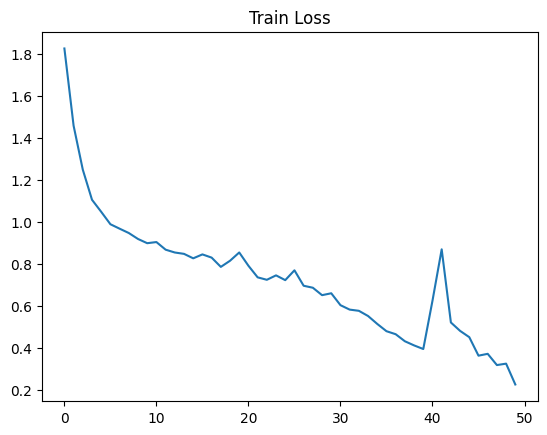

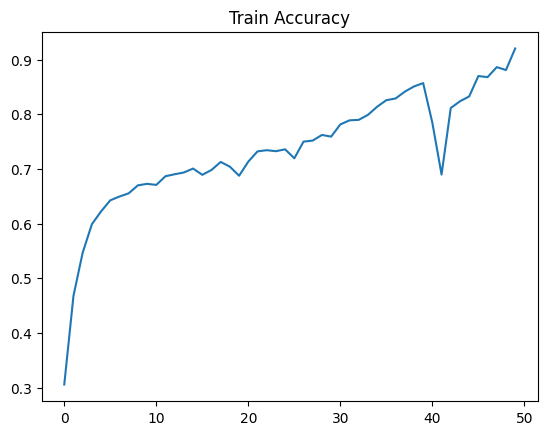

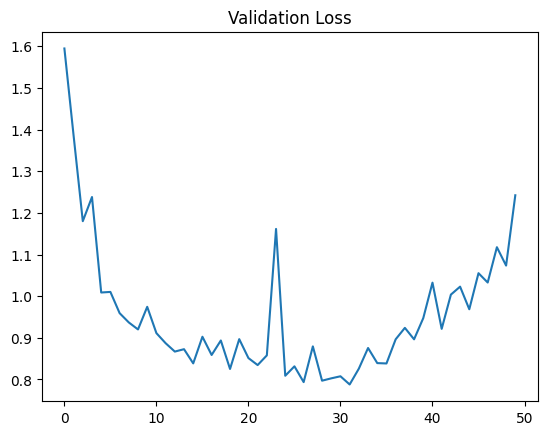

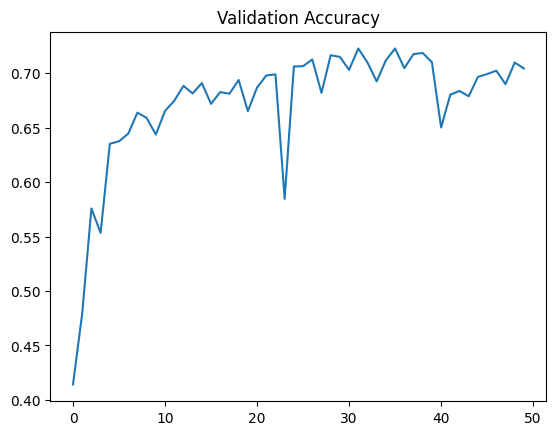

In [21]:
plt.plot(range(epochs), losses['train_losses'])
plt.title('Train Loss')
plt.show()

plt.plot(range(epochs), metrics['train_metrics'])
plt.title('Train Accuracy')
plt.show()

plt.plot(range(epochs), losses['val_losses'])
plt.title('Validation Loss')
plt.show()

plt.plot(range(epochs), metrics['val_metrics'])
plt.title('Validation Accuracy')
plt.show()

## Test

In [22]:
test_metrics = test(new_model, test_loader, conf_train)
print(test_metrics)

tensor(0.6947, device='cuda:0')
